# Machine learning, but not understanding

CAP 6635 Artifical Intelligence Spring 2021
Christian Garbin

In the expression "machine learning", are the machines actually learning anything?

In the book "Artifical Intelligence, a guide for thinking humans" Melanie Mitchell explains that

> "Learning in neural networks simply consists in gradually modifying the weights on connections so that each output’s error gets as close to 0 as possible on all training examples."

Let's explore what "learning" means for machine learning, guided by Mitchell's book. More specifically, we will concentrate on "deep learning", a branch of machine learning that has powered most of the recent advances in artificial intelligence.

Credit where credit is due: all quoted text comes from Mitchell's excellent book.

## An extremely short explanation of deep learning

Deep learning uses layers of "units" (also called "neurons", but some people, including Mitchell and I, prefer the more generic "units" term, to not confuse with actual neurons) to extract patterns from labeled data. The internal layers are called "hidden layers". The last layer is called the "output layer", or the classification layer.

In the following figure (from Mitchell's book, chapter 2), a neural network comprised of several hidden layers (only one shown) was trained to classify handwritten digits. The output layer has ten units, one for each possible digit.

![Neural network](pics/neural-network.png)

How does a neural network learn? Back to Mitchell’s quote:

> "Learning in neural networks simply consists in gradually modifying the weights on connections so that each output’s error gets as close to 0 as possible on all training examples."

Going through the sentence pieces:

- _training examples_: The labeled examples we present to the network to train it. For example, we present a picture of a square or a triangle and its corresponding label, "square" or "triangle", respectively.
- _output's error_: How far the network's prediction is from the correct label of the example picture.
- _weights on connections_: A large-precision decimal number (several digits after the dot) that adjusts the output of a unit in one layer to the input of a unit in the next layer. The weights are where the "knowledge" of the neural network is encoded.
- _gradually modifying_: This is the neural network learning process. An algorithm carefully modifies the weights on the connections to get closer to the expected output. Repeating the adjustment step over time (many, many times) allows the network to learn from the training examples.

## An important consequence of this process

> The machine learns what it observes in the data rather than what you (the human) might observe. If there are statistical associations in the training data, even if irrelevant to the task at hand, the machine will happily learn those instead of what you wanted it to learn.

Thus, neural networks are not "learning" in the sense that we would understand the term. They are not learning higher-level concepts from the samples used to train them. They are extracting patterns from the data presented to them during training (and they assume that the labels are correct). That's all.

Or, as Mitchell puts more eloquently:

> The phrase “barrier of meaning” perfectly captures an idea that has permeated this book: humans, in some deep and essential way, understand the situations they encounter, whereas no AI system yet possesses such understanding. While state-of-the-art AI systems have nearly equaled (and in some cases surpassed) humans on certain narrowly defined tasks, these systems all lack a grasp of the rich meanings humans bring to bear in perception, language, and reasoning. This lack of understanding is clearly revealed by the un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge; ... The barrier of meaning between AI and human-level intelligence still stands today.

Should we be concerned that deep learning is not "learning"? We should, if we don't understand what it implies for real-life applications.

In the next sections we will explore how neural networks lack the grasp of "rich meanings we humans bring to bear in perception", illustrating it with some "un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge".

## Telling squares and triangles apart

We will see how a neural network trained to tell squares and triangles apart behaves.

For human beings, the pictures below show squares and triangles. Some are small, some are large, some are in a light background, some are in a darker background. But they are all clearly either a square or a triangle in a frame.

![Squares and triangles](pics/squares-triangles.png)


In this section we will go through the typical process of training a neural network to classify squares and triangles:

1. Get a dataset with labeled pictures of squares and triangles
1. Split the dataset into a training set and a test set
1. Train the network with the training set
1. Validate its accuracy with the test set

After we are done with that, we will predict similar images to see how the network handles them.

First, load some of the frameworks we need and prepare the environment.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import images

%matplotlib inline

# To increase reproducibility (although it's not guaranteed)
# Based on https://stackoverflow.com/a/52897216
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
                   
images.create_datasets()             

2022-12-15 15:17:13.785533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### The "squares vs. triangles" training examples

Load the square and triangle training examples.

In [2]:
(train_set, train_label), (test_set, test_label) = images.get_upright_dataset(10)
class_names = images.get_class_labels()

This is how some of the training images look like. Each picture is a square or a triangle in different positions. The dataset has hundreds of these pictures.

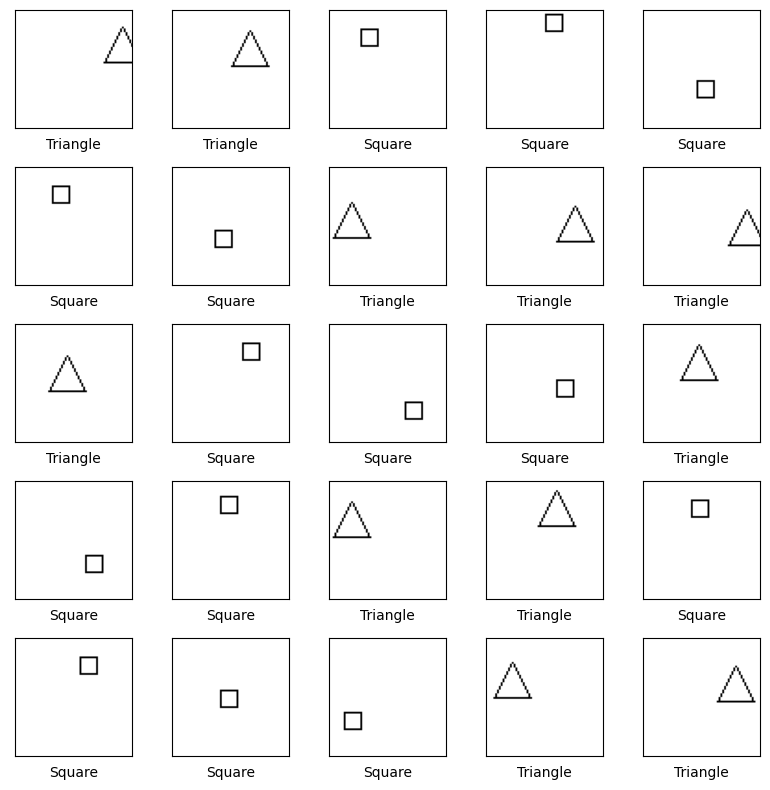

In [3]:
def draw_pictures(pictures, labels, figsize, count, ncols):
    plt.figure(figsize=figsize)
    for i in range(count):
        plt.subplot(count // ncols, ncols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pictures[i], cmap='gray', vmin=0, vmax=255)
        if labels is not None:
            plt.xlabel(class_names[labels[i]])
    plt.tight_layout()
    plt.show()

draw_pictures(train_set, train_label, (8,8), 25, 5)

### The "square vs. triangle" neural network

We will now train a [convolutional neural network](https://cs231n.github.io/convolutional-networks/) (CNN) to classify a picture as a "square" or as a "triangle", using the training examples. We chose a CNN architecture because it is well suited to image classification.

The code is based on the [TensorFlow classification tutorial](https://www.tensorflow.org/tutorials/keras/classification) and the [TensorFlow CNN classification tutorial](https://www.tensorflow.org/tutorials/images/cnn).

In [4]:
train_set, train_label = images.prepare_set(train_set, train_label)
test_set, test_label = images.prepare_set(test_set, test_label)

In [5]:
INPUT_SHAPE = (images.CANVAS_SIZE, images.CANVAS_SIZE, 1)
NUM_CLASSES = len(class_names)

def get_model():
    """Return a compiled model, ready to be trained."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                               input_shape=INPUT_SHAPE),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model


In [6]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, verbose=1,
    restore_best_weights=True)

In [7]:
BATCH_SIZE = 64
EPOCHS = 5

model = get_model()
model.fit(train_set, train_label, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=(test_set, test_label), callbacks=[callback])

2022-12-15 15:17:23.229470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
10/10 [==============================] - 6s 438ms/step - loss: 1.3003 - accuracy: 0.5098 - val_loss: 0.6919 - val_accuracy: 0.5075
Epoch 2/5
10/10 [==============================] - 5s 501ms/step - loss: 0.6855 - accuracy: 0.5798 - val_loss: 0.6554 - val_accuracy: 0.5672
Epoch 3/5
10/10 [==============================] - 5s 458ms/step - loss: 0.6010 - accuracy: 0.6922 - val_loss: 0.5287 - val_accuracy: 0.7164
Epoch 4/5
10/10 [==============================] - 6s 606ms/step - loss: 0.4333 - accuracy: 0.7866 - val_loss: 0.3831 - val_accuracy: 0.8657
Epoch 5/5
10/10 [==============================] - 6s 570ms/step - loss: 0.2122 - accuracy: 0.9365 - val_loss: 0.2574 - val_accuracy: 0.9403


### How does the neural network perform?

Before we started the training process, we set aside 10% of the pictures to use later. They are pictures that the neural network was not trained on. This is the _test set_. We use the test set to measure the performance of the neural network.

A traditional measure of performance is "accuracy". It measures the percentage of pictures in the test set that were correctly classified.

First, we ask the neural network to predict what the pictures are (more details on how that happens [here](https://github.com/fau-masters-collected-works-cgarbin/decision-threshold-effect-on-accuracy)).

In [8]:
pred_prob = model.predict(test_set)
pred_label = np.argmax(pred_prob, axis=1)

3/3 [==============================] - 0s 22ms/step


Now we compare with the actual labels and calculate the accuracy.

In [9]:
pred_correct = pred_label == test_label.flatten()
num_labels = len(test_label)
print('Out of {} pictures, {} were classified correctly'.format
     (num_labels, sum(pred_correct)))
print('Accuracy = {:.1%}'.format(sum(pred_correct) / num_labels))

Out of 67 pictures, 63 were classified correctly
Accuracy = 94.0%


This is a pretty good accuracy for a relatively small neural network that can be trained quickly.

Let's visualize where the neural network made the mistakes. The picture below shows the mistakes with a red border. All other pictures were classified correctly. Below each picture is the neural network's classification.

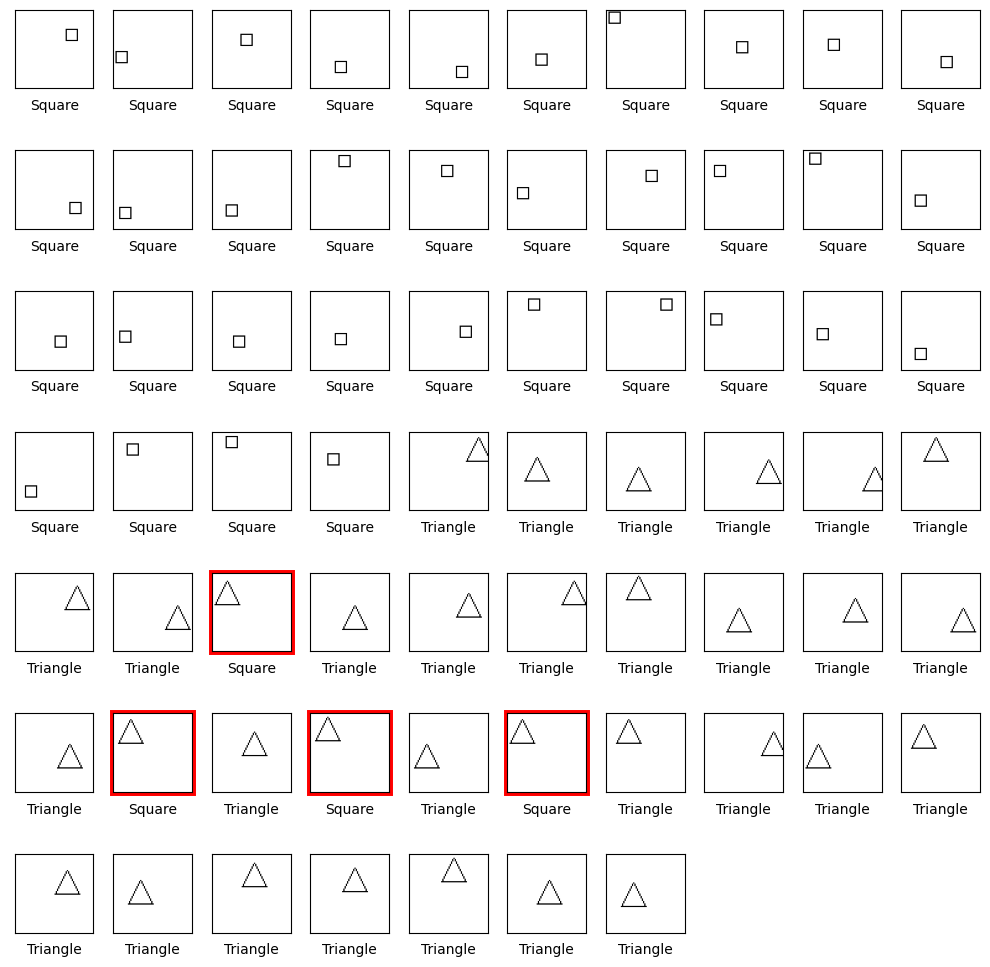

In [10]:
plt.figure(figsize=(10,10))
for i in range(num_labels):
    ax = plt.subplot(7, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if pred_label[i] != test_label[i][0]:
        ax.patch.set_color('red')
        ax.patch.set_linewidth(5)
    plt.imshow(test_set[i], cmap='gray', vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

Despite the good accuracy, does the neural network understand the concept of what it is learning?

### When are squares not squares?

When they are larger. At least for this neural network.

In this section we will use the neural network we just trained to classify a set of squares. But there is a twist to these squares: they are larger than the ones we used in the training set.

This is how some of them look like.

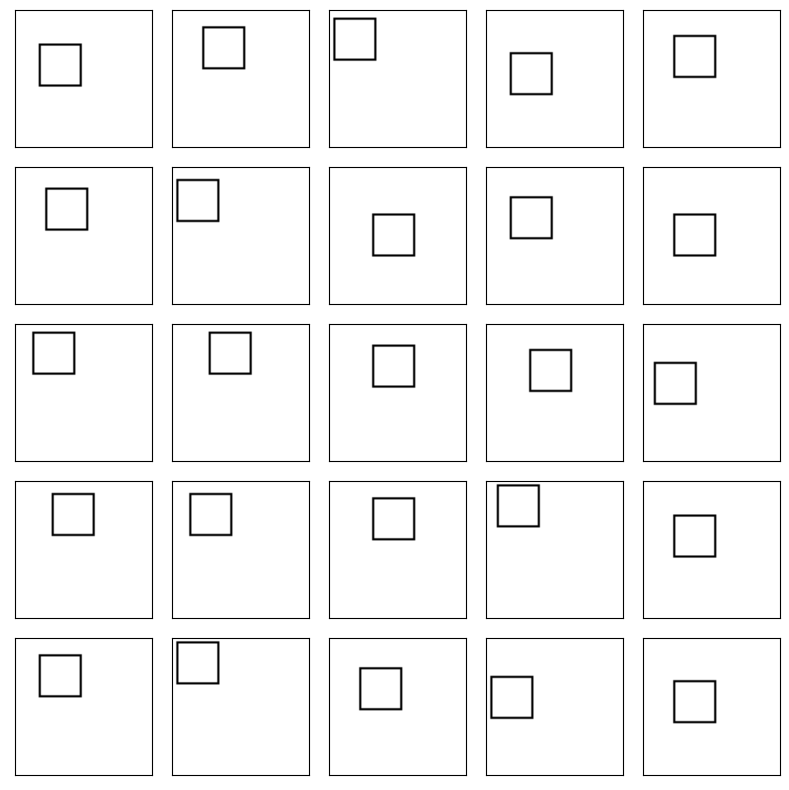

In [11]:
large_squares = images.get_square_large_dataset()
draw_pictures(large_squares, None, (8,8), 25, 5)

Using the neural network, we classify the large squares.

In [12]:
large_squares, _ = images.prepare_set(large_squares)
pred_prob = model.predict(large_squares)
pred_label = np.argmax(pred_prob, axis=1)

3/3 [==============================] - 0s 43ms/step


This is the accuracy of the classification.

In [13]:
pred_correct = pred_label == images.LABEL_SQUARE
num_labels = len(pred_label)
print('Out of {} pictures, {} were classified correctly'.format
     (num_labels, sum(pred_correct)))
print('Accuracy = {:.1%}'.format(sum(pred_correct) / num_labels))

Out of 77 pictures, 37 were classified correctly
Accuracy = 48.1%


That's significantly worse than the accuracy on upright squares.

Below are all the squares in this set and how the neural network classified them. The ones with the red border were incorrectly classified as triangles (there are many of them).

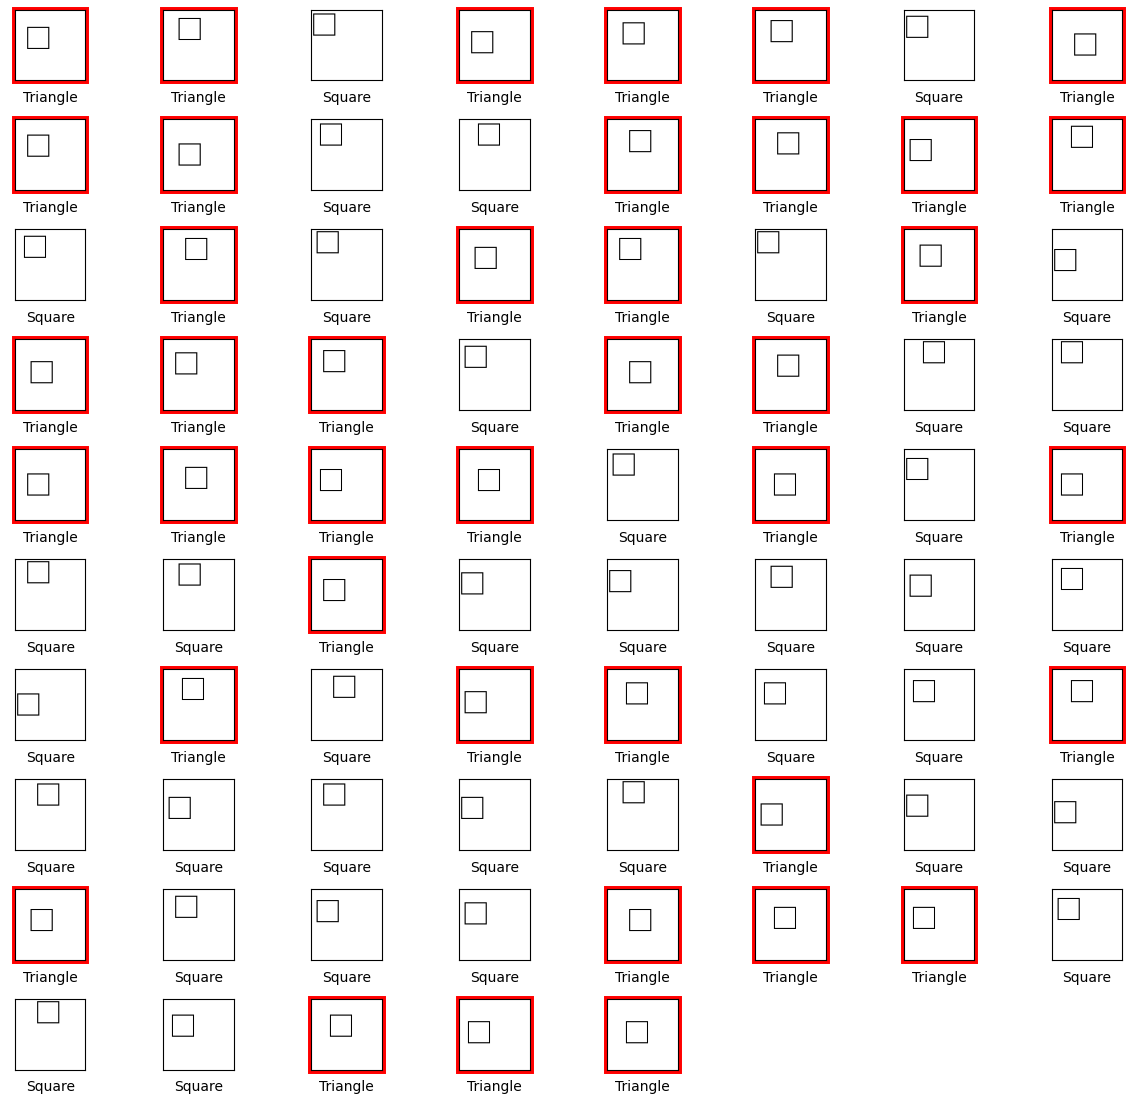

In [14]:
plt.figure(figsize=(12,12))
for i in range(77):
    ax = plt.subplot(11, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if pred_label[i] != images.LABEL_SQUARE:
        ax.patch.set_color('red')
        ax.patch.set_linewidth(5)
    plt.imshow(large_squares[i], cmap='gray', vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

### Why does this experiment matter?

The simplest and fastest way to improve this neural network is to increase the size of the training and test sets. In this case, we should add larger squares to the training set and retrain the neural network. It will very likely perform better.

But this does not address the fundamental problem: ***the neural network does not understand the concept of "square".***

Quoting Mitchell again (emphasis added):

> The phrase “barrier of meaning” perfectly captures an idea that has permeated this book: humans, in some deep and essential way, understand the situations they encounter, whereas no AI system yet possesses such understanding. While state-of-the-art AI systems have nearly equaled (and in some cases surpassed) humans on certain narrowly defined tasks, ***these systems all lack a grasp of the rich meanings humans bring to bear in perception, language, and reasoning. This lack of understanding is clearly revealed by the un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge;*** ... The barrier of meaning between AI and human-level intelligence still stands today.

Even if we collect lots and lots and lots of example, we are confronted with ***the long-tail problem***:

> the vast range of possible unexpected situations an AI system could be faced with.

For example, let's say we trained our autonomous driving system to recognize a school zone by the warning sign painted on the road ([source](https://virtualdriveoftexas.com/texas-school-zones/)):

![](pics/school-spelled-right.png)

Then, one day our autonomous driving system comes across these real-life examples (image sources: [1](https://www.anyvan.com/blog/whats-going-on/back-to-shcool-for-some/), [2](https://www.wibw.com/content/news/School-misspelled-at-Florida-crosswalk-508798331.html?ref=331)):

| ![](pics/school-spelled-wrong-1.png) | ![](pics/school-spelled-wrong-2.png) |

Any (well, most) human beings would still identify them as warning signs for school zones (presumably, the human would chuckle, then - hopefully - slow down).

Would the autonomous driving system identify them correctly? The honest answer is "we don't know". It depends on how it was trained. Was it given these examples in the training set? In enough quantities to identify the pattern? Did the test set have examples? Were they classified correctly?

But no matter how comprehensive we make the training and test sets and how methodically we inspect the classification results, we are faced with the fundamental problem: ***the neural network does not understand the concept of "school zone warning"***.

The autonomous driving system lacks common sense.

> ...humans also have a fundamental competence lacking in all current AI systems: common sense. We have vast background knowledge of the world, both its physical and its social aspects.

The neural network may be _learning_, but it is definitely not _understanding_.

## Not understanding "squares" - part 2

In the first section we changed the shape of an object. In this section we will not change the object. We will change the environment instead.

We will train a neural network to classify squares and triangles again. This time they are in different environments, represented by different background colors. The squares are in a lighter background and the triangles are on a dark(er) background (we can think of the background as "twilight" and "night").

The picture below shows how they look like.

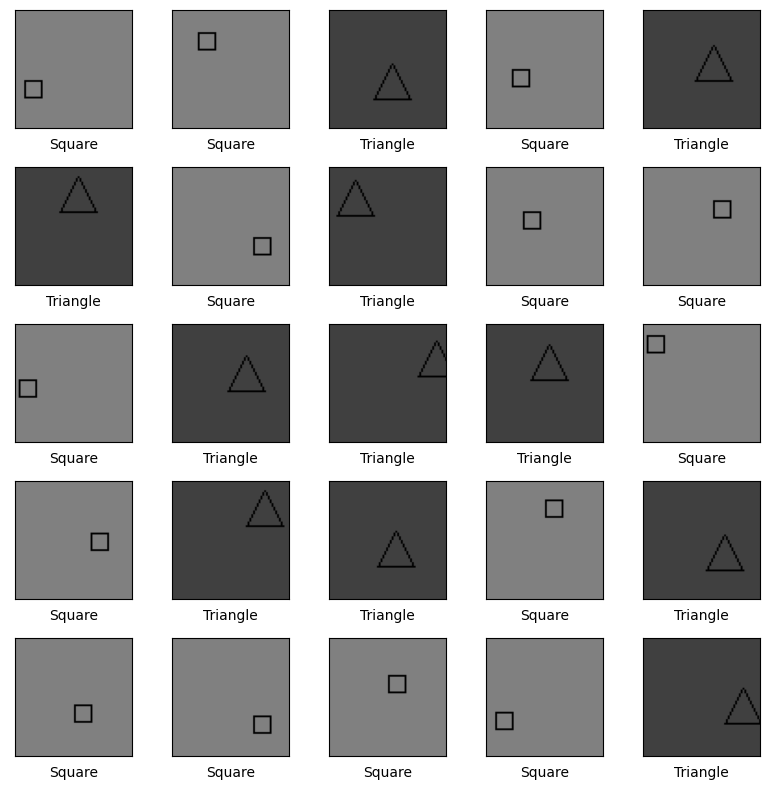

In [15]:
(train_set, train_label), (test_set, test_label) = images.get_color_dataset(10)
class_names = images.get_class_labels()

draw_pictures(train_set, train_label, (8,8), 25, 5)

Following the same steps we used in the first section, we will train a neural network to classify the squares and triangles.

In [16]:
train_set, train_label = images.prepare_set(train_set, train_label)
test_set, test_label = images.prepare_set(test_set, test_label)

In [17]:
model2 = get_model()
model2.fit(train_set, train_label, batch_size=BATCH_SIZE, epochs=EPOCHS,
           validation_data=(test_set, test_label), callbacks=[callback])

Epoch 1/5
10/10 [==============================] - 5s 390ms/step - loss: 0.7499 - accuracy: 0.5098 - val_loss: 0.6462 - val_accuracy: 0.5075
Epoch 2/5
10/10 [==============================] - 4s 404ms/step - loss: 0.6439 - accuracy: 0.5065 - val_loss: 0.6186 - val_accuracy: 0.5075
Epoch 3/5
10/10 [==============================] - 4s 433ms/step - loss: 0.5798 - accuracy: 0.5065 - val_loss: 0.4913 - val_accuracy: 0.5075
Epoch 4/5
10/10 [==============================] - 6s 559ms/step - loss: 0.3577 - accuracy: 0.8876 - val_loss: 0.1246 - val_accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 5s 524ms/step - loss: 0.0379 - accuracy: 1.0000 - val_loss: 7.9780e-04 - val_accuracy: 1.0000


Now we calculate how accurate the neural network is using the test set.

In [18]:
pred_prob = model2.predict(test_set)
pred_label = np.argmax(pred_prob, axis=1)

3/3 [==============================] - 0s 19ms/step


In [19]:
pred_correct = pred_label == test_label.flatten()
num_labels = len(test_label)
print('Out of {} pictures, {} were classified correctly'.format
     (num_labels, sum(pred_correct)))
print('Accuracy = {:.1%}'.format(sum(pred_correct) / num_labels))

Out of 67 pictures, 67 were classified correctly
Accuracy = 100.0%


A perfect score. All squares and triangles in the test set were classified correctly.

So far, so good, but...

### In the dark, all squares are triangles

What happens if the squares are now in the same environment as the triangles (all squares are in the "night" environment)?

This is how the squares look like in the darker environment.

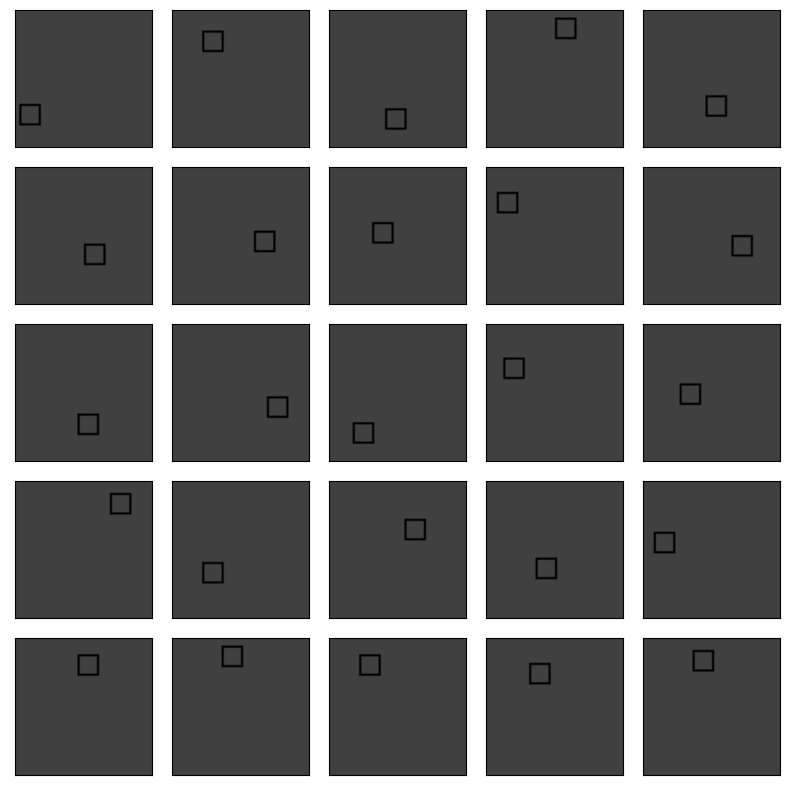

In [20]:
dark_squares = images.get_square_dark_gray_dataset()
draw_pictures(dark_squares, None, (8,8), 25, 5)

When we ask the neural network to classify these squares, this is what we get.

In [21]:
dark_squares, _ = images.prepare_set(dark_squares)

pred_prob = model2.predict(dark_squares)
pred_label = np.argmax(pred_prob, axis=1)

11/11 [==============================] - 0s 32ms/step


In [22]:
pred_correct = pred_label == images.LABEL_SQUARE
num_labels = len(test_label)
print('Out of {} pictures, {} were classified correctly'.format
     (num_labels, sum(pred_correct)))
print('Accuracy = {:.1%}'.format(sum(pred_correct) / num_labels))

Out of 67 pictures, 0 were classified correctly
Accuracy = 0.0%


The performance is now abysmal. All squares are misclassified as triangles.

To confirm, we can visualize the predictions. The wrong predictions have a red frame around them (all of them are wrong in this case).

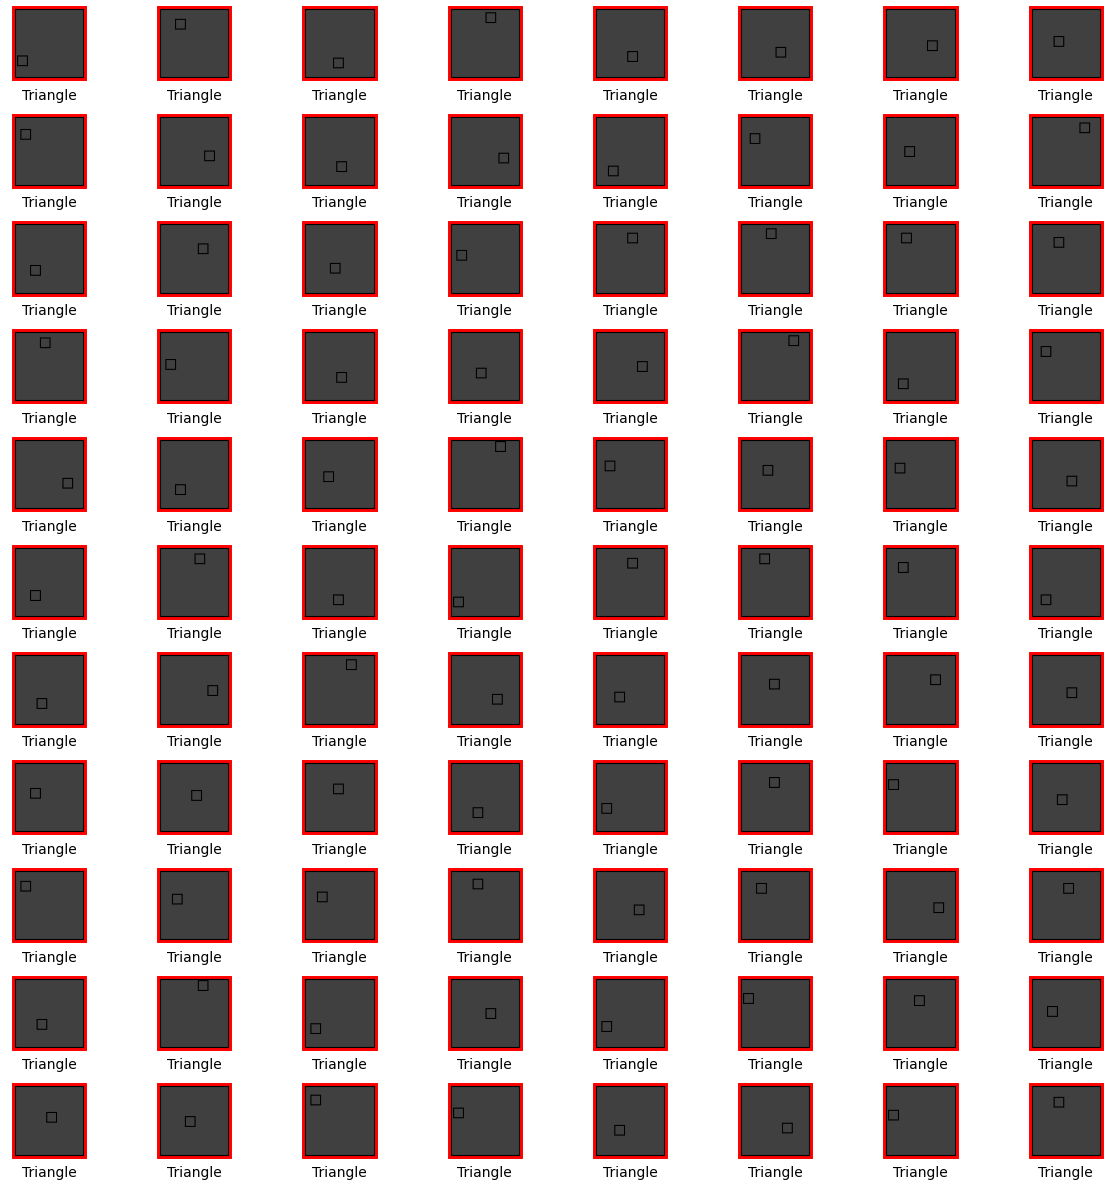

In [23]:
plt.figure(figsize=(12,12))
for i in range(88):
    ax = plt.subplot(11, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if pred_label[i] != images.LABEL_SQUARE:
        ax.patch.set_color('red')
        ax.patch.set_linewidth(5)
    plt.imshow(dark_squares[i], cmap='gray', vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

### Why does this experiment matter?

The neural network we just trained fails in the same way the first neural network failed. This neural network...

> (...) lack(s) a grasp of the rich meanings humans bring to bear in perception, language, and reasoning. This lack of understanding is clearly revealed by the un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge;

In this case, the neural network is very likely learning not from the shape, but from the background (a case of [spurious correlation](https://arxiv.org/pdf/1907.02893.pdf)). It is assuming that a darker background means "triangle" because it doesn't really understand the concept of what makes a triangle a triangle.

Sometimes this leads to some funny examples, like the neural network that "learned" to classify land vs. water birds based on the background. The duck on the right was misclassified as a land bird, simply because it was not in its usual water environment ([source](https://arxiv.org/abs/2005.04345)).

![](pics/land-and-waterbirds.png)

Other times the mistakes are more consequential, for example, when neural networks misclassify X-rays based on markings left by radiologists in the images. Instead of learning actual attributes of a disease, the neural network "learned" from the marks left behind in the images ([source](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf)). Images without such marks may be classified as "healthy". The consequences can be catastrophic.

![](pics/x-ray-pen-marks.png)

## Should we be concerned that deep "learning" is not "understanding"?

Mitchell asks the following question in her book:

> but the question remains: Will the fact that these systems lack humanlike understanding inevitably render them fragile, unreliable, and vulnerable to attacks? And how should this factor into our decisions about applying AI systems in the real world?

Until we achieve humanlike understanding, we should be concerned that neural networks do not generalize well.

Does it mean we need to stop using neural networks until then? No.

> I think the most worrisome aspect of AI systems in the short term is that we will give them too much autonomy without being fully aware of their limitations and vulnerabilities.

Deep learning has successfully improved our lives. It's "just" a matter of understanding its limitations, applying it judiciously, for the tasks that it's well suited.

To do that we need to educate the general public and, more importantly, the technical community. Too often we hype the next "AI has achieved humanlike performance in (some task here)", when in fact we should say "under these specific circumstances, for this specific application, AI has performed well".